In [1]:
import cv2

import matplotlib.pyplot as plt

import numpy as np

from skimage.filters import threshold_otsu
from skimage.io import imread
from skimage.morphology import skeletonize

from sklearn.neighbors import NearestNeighbors
import networkx as nx

import CriticalPointDetection
import BezierFit

%matplotlib inline

Text(0.5, 0.98, 'Sketch Image')

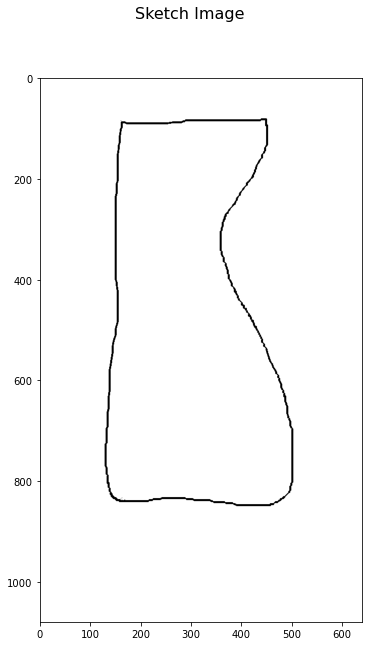

In [2]:
# Read and display the image 
image = imread('E:/University Work/Research/DocEng Book Series/Code Examples/Test1.png', as_gray=True).astype(np.uint8)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)
ax.imshow(image, cmap='gray')
fig.suptitle('Sketch Image', fontsize=16)

In [3]:
# Obtain a vector representation of the drawing

# the error tolerance value
err = 9;

# find the vecotr points 
x, y, idx = CriticalPointDetection.Sklansky(image, err)

C:\Users\alexa\Anaconda3\envs\DocEngExamples\lib\site-packages\skimage\util\dtype.py:525: UserWarning: Downcasting int32 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)


Text(0.5, 0.98, 'Polygonal fit of the sketch')

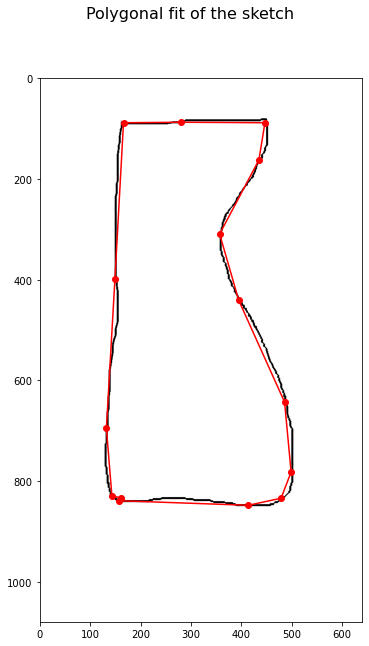

In [4]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)
ax.imshow(image, cmap='gray')
plt.plot(x[idx], y[idx], 'r-o')

fig.suptitle('Polygonal fit of the sketch', fontsize=16)

In [7]:
# Perform Bezier curve fitting on the polyfit segments

# initialise the curve
Curve = np.zeros((1, 2))

# loop through the polylines
for n in range(0, len(idx) - 1, 1):
    
    # intialise the vector points to zeros
    VectorPoints = np.zeros((len(x[idx[n] : idx[n + 1]]), 2))
    
    # write in the curve stroke points
    VectorPoints[:, 1] = x[idx[n] : idx[n + 1]]
    VectorPoints[:, 0] = y[idx[n] : idx[n + 1]]
    
    # estimate the tangents - taking into consideration central tangents for continuity - using a wider tangent support segment to obtain better tangent estimates
    t_env = 15
    if n == 0:
        # the first line segment tangent
        LT = (VectorPoints[t_env] - VectorPoints[0])/np.linalg.norm(VectorPoints[2] - VectorPoints[0])
    
    else:
    
        # central tangents
        LT = np.zeros((t_env, 2))
        for p in range(0, t_env):
            
            P = np.zeros((len(x[idx[n] - (p + 1) : idx[n] + p + 1]), 2))
            P[:, 1] = x[idx[n] - (p + 1) : idx[n] + p + 1] 
            P[:, 0] = y[idx[n] - (p + 1)  : idx[n] + p + 1]
            
            LT[p, :] = (P[-1] - P[0])/np.linalg.norm(P[-1] - P[0])
        
        LT = np.median(LT, axis = 0)
    
    if n < len(idx) - 1:
        
        # central tangents
        RT = np.zeros((t_env, 2))
        for p in range(0, t_env):
            
            P = np.zeros((len(x[idx[n+1] - (p+1) : idx[n+1] + (p+1)]), 2))
            P[:, 1] = x[idx[n + 1] - (p+1) : idx[n + 1] + (p+1)] 
            P[:, 0] = y[idx[n + 1] - (p+1) : idx[n + 1] + (p+1)]
            RT[p, :] = (P[0] - P[-1])/np.linalg.norm(P[0] - P[-1])
            
        RT = np.median(RT, axis = 0)
        
    else:
        
        # the last line segment tangent
        RT = (VectorPoints[-t_env] - VectorPoints[-1])/np.linalg.norm(VectorPoints[-4] - VectorPoints[-1])
    
       
    # fit Schneider's bezier curve control points
    CLP = BezierFit.ChordLengthParameterisaion(VectorPoints) # chord length parameterisation 
    ctrlPoly_SE = BezierFit.generateBezier_Schneider(VectorPoints, CLP, LT, RT)
    
    # Apply Newton-Raphson Optimisation
    CLP_Prime = [BezierFit.NewtonRaphsonRootFinder(ctrlPoly_SE, point, u) for point, u in zip(VectorPoints, CLP)]
    ctrlPoly_SE = BezierFit.generateBezier_Schneider(VectorPoints, CLP_Prime, LT, RT)
    
    # fit the Bezier curve to these points
    Points_SE = np.zeros((101, 2)) # initalise the curve array
    
    # loop through all points along the curve
    for k in range(0, 101, 1):
    
        t = k/100
    
        # Bernstein's polynomial at point (t)
        Points_SE[k, :] = BezierFit.CubicBezierCurveValue(ctrlPoly_SE, t)

    Curve = np.concatenate((Curve, Points_SE), axis = 0)

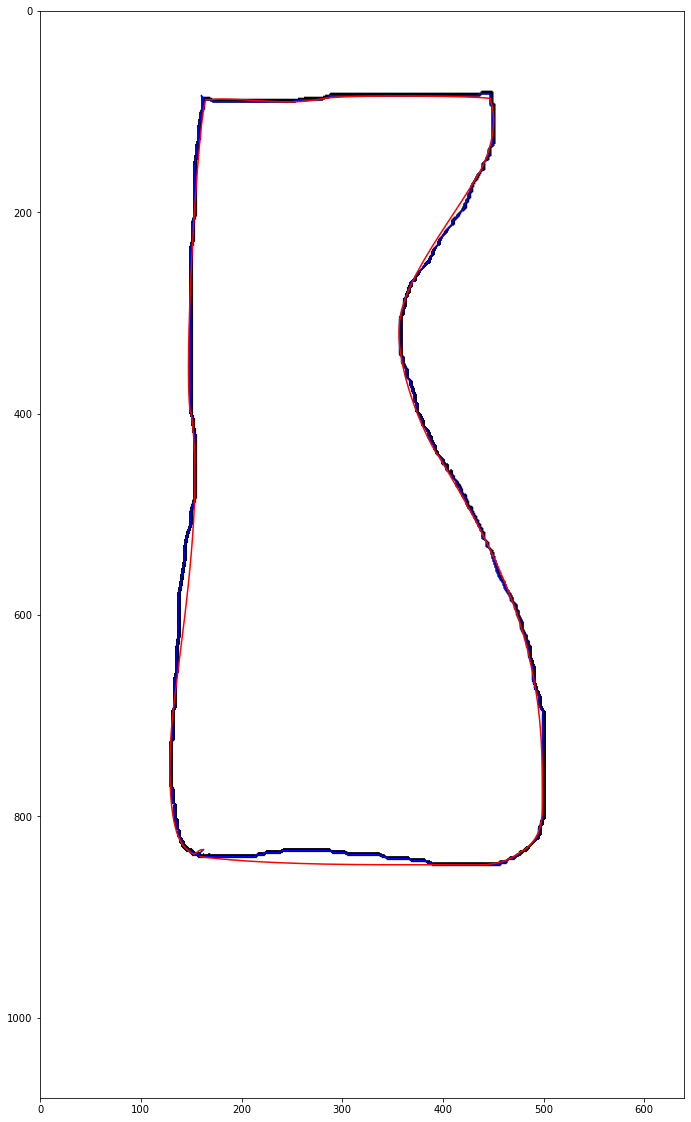

In [8]:
fig = plt.figure(figsize=(12, 20))
ax = fig.add_subplot(111)
ax.imshow(image, cmap='gray')
plt.plot(x, y, 'b')
plt.plot(Curve[1:, 1], Curve[1:, 0], 'r-')
